In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import json
import sys

# load flight data from json file
result_file = 'processed_flights_data.json'

with open(result_file, 'r', encoding='utf-8') as file:
    final_processed_flights = json.load(file)

Number of flights in data: 2127
Sample flight data: {'departure_airport_code': 'LGA', 'arrival_airport_code': 'DFW', 'departure_datetime_obj': '2025-07-20T22:00:00', 'arrival_datetime_obj': '2025-07-21T00:50:00', 'duration_time': 230, 'price_usd': 108.57000000000001, 'airline': 'Frontier;'}
Number of nodes: 26
Number of edges: 85
Edges added: 2127


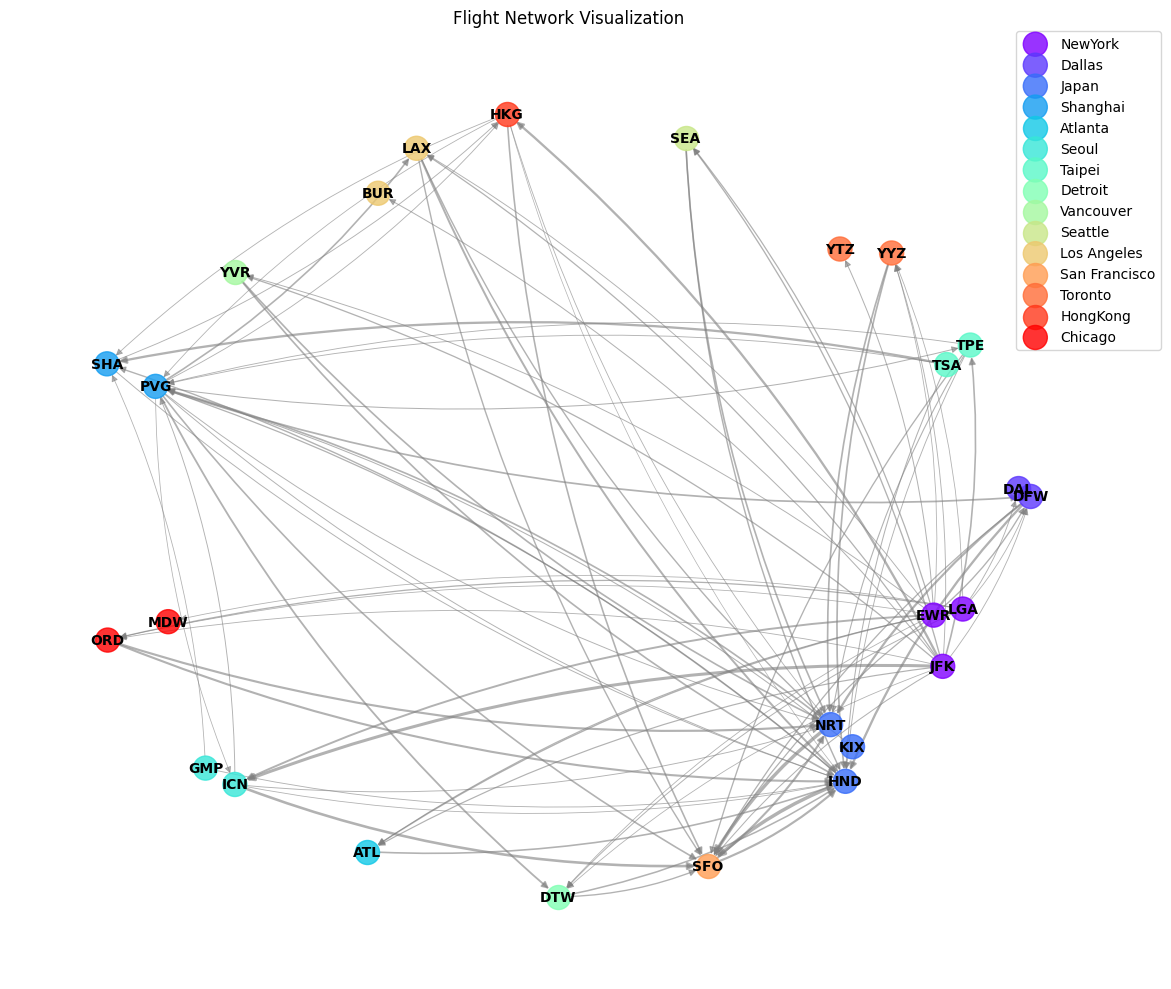

In [2]:
# first validate the flight data
print(f'Number of flights in data: {len(final_processed_flights)}')
if len(final_processed_flights) > 0:
    print('Sample flight data:', final_processed_flights[0])

# create directed graph
G = nx.DiGraph()

# airport to city mapping (fixed spacing issues)
airport_to_city = {
    'JFK': 'NewYork',
    'LGA': 'NewYork',
    'EWR': 'NewYork',
    'ATL': 'Atlanta',
    'ORD': 'Chicago',
    'MDW': 'Chicago',
    'DFW': 'Dallas',
    'DAL': 'Dallas',
    'DTW': 'Detroit',
    'HKG': 'HongKong',
    'LAX': 'Los Angeles',
    'BUR': 'Los Angeles',
    'SFO': 'San Francisco',
    'SEA': 'Seattle',
    'ICN': 'Seoul',
    'GMP': 'Seoul',
    'TPE': 'Taipei',
    'TSA': 'Taipei',
    'YVR': 'Vancouver',
    'NRT': 'Japan',
    'HND': 'Japan',
    'KIX': 'Japan',
    'YYZ': 'Toronto',
    'YTZ': 'Toronto',
    'PVG': 'Shanghai',
    'SHA': 'Shanghai',
    "IAD": "Washington DC",  
    "DCA": "Washington DC",  
    "BWI": "Washington DC",  
}

# add nodes and edges
edges_added = 0
for flight in final_processed_flights:
    try:
        dep = flight['departure_airport_code'].strip()
        arr = flight['arrival_airport_code'].strip()  
        price = flight['price_usd']

        # add nodes if they don't exist
        if dep not in G:
            G.add_node(dep, city=airport_to_city.get(dep, 'Unknown'))
        if arr not in G:
            G.add_node(arr, city=airport_to_city.get(arr, 'Unknown'))
        
        # add edge with price and airline info
        G.add_edge(dep, arr, weight=price, airline=flight['airline'])
        edges_added += 1
    except Exception as e:
        print(f'Error processing flight: {flight}')
        print(f'Error details: {e}')

print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')
print(f'Edges added: {edges_added}')

# exit if no edges were created
if G.number_of_edges() == 0:
    print('No edges were added to the graph. Check the flight data format.')
    print('Expected keys in flight data:')
    print('- departure_airport_code')
    print('- arrival_airport_code')
    print('- price_usd')
    print('- airline')
    
    # check actual keys in the data
    if len(final_processed_flights) > 0:
        print('\nActual keys in the first flight data:')
        print(list(final_processed_flights[0].keys()))
    
    # exit the program
    sys.exit('Exiting due to no edges in graph')

# visualization (only executed if graph has edges)
# create circular layout by city
cities = list(set(airport_to_city.values()))
city_pos = {}
np.random.seed(42)  # For reproducible layout
for i, city in enumerate(cities):
    angle = 2 * np.pi * i / len(cities)
    city_pos[city] = (np.cos(angle), np.sin(angle))

# assign positions to each airport with small random offsets
node_pos = {}
for node in G.nodes():
    city = G.nodes[node].get('city', 'Unknown')
    if city in city_pos:
        offset_x = np.random.uniform(-0.1, 0.1)
        offset_y = np.random.uniform(-0.1, 0.1)
        node_pos[node] = (city_pos[city][0] + offset_x, city_pos[city][1] + offset_y)
    else:
        node_pos[node] = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))

# create visualization
plt.figure(figsize=(12, 10))

# group nodes by city
city_to_nodes = {}
for node in G.nodes():
    city = G.nodes[node].get('city', 'Unknown')
    if city not in city_to_nodes:
        city_to_nodes[city] = []
    city_to_nodes[city].append(node)

# draw nodes with different colors per city
colors = plt.cm.rainbow(np.linspace(0, 1, len(city_to_nodes)))
for i, (city, nodes) in enumerate(city_to_nodes.items()):
    nx.draw_networkx_nodes(G, node_pos, nodelist=nodes, node_color=[colors[i]] * len(nodes), 
                         node_size=300, alpha=0.8, label=city)

# draw edges with width proportional to price
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
min_weight = min(edge_weights) if edge_weights else 0
max_weight = max(edge_weights) if edge_weights else 1
norm_weights = [(w - min_weight) / (max_weight - min_weight) * 2 + 0.5 
               if max_weight > min_weight else 1 for w in edge_weights]

nx.draw_networkx_edges(G, node_pos, width=norm_weights, edge_color='gray', alpha=0.6,
                      connectionstyle='arc3,rad=0.1')

# add labels and legend
nx.draw_networkx_labels(G, node_pos, font_size=10, font_weight='bold')
plt.legend(scatterpoints=1, bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.title('Flight Network Visualization')
plt.axis('off')
plt.tight_layout()
plt.savefig('graph.png')
plt.show()

In [3]:
# define sets of origin and destination airports
nyc_airports = ['JFK', 'LGA', 'EWR']  # New York airports
japan_airports = ['NRT', 'HND', 'KIX']  # Japan airports
shanghai_airports = ['PVG', 'SHA']  # Shanghai airports

best_price = float('inf')  
best_path = None  

# check all possible origin-destination pairs
for source in nyc_airports:
    for target in shanghai_airports:
        try:
            # find the shortest path using Dijkstra's algorithm (based on 'weight')
            path = nx.dijkstra_path(G, source, target, weight='weight')
            
            # calculate total cost (sum of edge weights along the path)
            cost = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))
            
            # update best path if a cheaper one is found
            if cost < best_price:
                best_price = cost
                best_path = path
                
        except nx.NetworkXNoPath:  # skip if no path exists
            continue

# print results
if best_path:
    print('Cheapest flight route:', best_path)
    print('Total price: USD', round(best_price, 2))
else:
    print('No flight path found from NYC to Japan.')

Cheapest flight route: ['JFK', 'TPE', 'PVG']
Total price: USD 980.21
